## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
EPOCHS = 10 # IF you feel too run to finish, try to make it smaller
LEARNING_RATE = 1e-3
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""

reduce_lr_factor = [0.1, 0.5, 0.9]
redice_lr_patient = [1,5,9]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1) 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

Epoch 8/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.3923 - acc: 0.5128 - val_loss: 1.5270 - val_acc: 0.4615
Epoch 9/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.3634 - acc: 0.5234 - val_loss: 1.5258 - val_acc: 0.4592
Epoch 10/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.3358 - acc: 0.5344 - val_loss: 1.5102 - val_acc: 0.4623
Numbers of exp: 3, reduce_factor: 0.50, reduce_patient: 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
hi

Epoch 5/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.4991 - acc: 0.4730 - val_loss: 1.6099 - val_acc: 0.4350
Epoch 6/10
50000/50000 [==============================] - 2s 37us/step - loss: 1.4567 - acc: 0.4883 - val_loss: 1.5837 - val_acc: 0.4423
Epoch 7/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.4175 - acc: 0.5011 - val_loss: 1.5594 - val_acc: 0.4522
Epoch 8/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.3838 - acc: 0.5155 - val_loss: 1.5398 - val_acc: 0.4565
Epoch 9/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.3537 - acc: 0.5262 - val_loss: 1.5161 - val_acc: 0.4652
Epoch 10/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.3256 - acc: 0.5330 - val_loss: 1.5100 - val_acc: 0.4711
Numbers of exp: 6, reduce_factor: 0.90, reduce_patient: 1
_________________________________________________________________
Layer (type)                 Output Shape            

Epoch 2/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.7577 - acc: 0.3877 - val_loss: 1.8323 - val_acc: 0.3815
Epoch 3/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.6304 - acc: 0.4286 - val_loss: 1.7071 - val_acc: 0.4146
Epoch 4/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.5576 - acc: 0.4545 - val_loss: 1.6376 - val_acc: 0.4319
Epoch 5/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.5060 - acc: 0.4725 - val_loss: 1.5973 - val_acc: 0.4440
Epoch 6/10
50000/50000 [==============================] - 2s 37us/step - loss: 1.4645 - acc: 0.4858 - val_loss: 1.5893 - val_acc: 0.4454
Epoch 7/10
50000/50000 [==============================] - 2s 37us/step - loss: 1.4282 - acc: 0.4999 - val_loss: 1.5476 - val_acc: 0.4555
Epoch 8/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.3950 - acc: 0.5122 - val_loss: 1.5360 - val_acc: 0.4636
Epoch 9/10
50000/50000 [=================

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 74us/step - loss: 2.3387 - acc: 0.2432 - val_loss: 2.1875 - val_acc: 0.2865
Epoch 2/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.9282 - acc: 0.3383 - val_loss: 1.9589 - val_acc: 0.3276
Epoch 3/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.8216 - acc: 0.3697 - val_loss: 1.8757 - val_acc: 0.3566
Epoch 4/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.7555 - acc: 0.3887 - val_loss: 1.8120 - val_acc: 0.3701
Epoch 5/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.7106 - acc: 0.4034 - val_loss: 1.7786 - val_acc: 0.3754
Epoch 6/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.6745 - acc: 0.4157 - val_loss: 1.7439 - val_acc: 0.3854
Epoch 7/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.6441 - acc: 0.4259 - val_loss: 1.7221 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 94us/step - loss: 2.2474 - acc: 0.2545 - val_loss: 2.1222 - val_acc: 0.3067
Epoch 2/10
50000/50000 [==============================] - 2s 41us/step - loss: 1.8507 - acc: 0.3598 - val_loss: 1.9217 - val_acc: 0.3472
Epoch 3/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.7487 - acc: 0.3924 - val_loss: 1.8161 - val_acc: 0.3773
Epoch 4/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.6888 - acc: 0.4124 - val_loss: 1.7815 - val_acc: 0.3927
Epoch 5/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.6467 - acc: 0.4266 - val_loss: 1.7381 - val_acc: 0.3994
Epoch 6/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.6139 - acc: 0.4384 - val_loss: 1.7099 - val_acc: 0.4100
Epoch 7/10
50000/50000 [==============================] - 2s 42us/step - loss: 1.5859 - acc: 0.4478 - val_loss: 1.6842 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 85us/step - loss: 2.2293 - acc: 0.2620 - val_loss: 2.2338 - val_acc: 0.2976
Epoch 2/10
50000/50000 [==============================] - 2s 41us/step - loss: 1.8463 - acc: 0.3623 - val_loss: 1.9025 - val_acc: 0.3520
Epoch 3/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.7417 - acc: 0.3929 - val_loss: 1.8203 - val_acc: 0.3854
Epoch 4/10
50000/50000 [==============================] - 2s 43us/step - loss: 1.6804 - acc: 0.4121 - val_loss: 1.7892 - val_acc: 0.3891
Epoch 5/10
50000/50000 [==============================] - 2s 43us/step - loss: 1.6377 - acc: 0.4290 - val_loss: 1.7289 - val_acc: 0.4065
Epoch 6/10
50000/50000 [==============================] - 2s 43us/step - loss: 1.6038 - acc: 0.4399 - val_loss: 1.6990 - val_acc: 0.4189
Epoch 7/10
50000/50000 [==============================] - 2s 45us/step - loss: 1.5766 - acc: 0.4506 - val_loss: 1.6819 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 91us/step - loss: 1.9924 - acc: 0.3248 - val_loss: 1.9633 - val_acc: 0.3415
Epoch 2/10
50000/50000 [==============================] - 2s 41us/step - loss: 1.6808 - acc: 0.4138 - val_loss: 1.8473 - val_acc: 0.3684
Epoch 3/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.5649 - acc: 0.4535 - val_loss: 1.8073 - val_acc: 0.3791
Epoch 4/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.4837 - acc: 0.4807 - val_loss: 1.6413 - val_acc: 0.4255
Epoch 5/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.4238 - acc: 0.5030 - val_loss: 1.6948 - val_acc: 0.4146
Epoch 6/10
50000/50000 [==============================] - 2s 42us/step - loss: 1.3736 - acc: 0.5205 - val_loss: 1.6215 - val_acc: 0.4281
Epoch 7/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.3292 - acc: 0.5364 - val_loss: 1.5779 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 91us/step - loss: 2.3730 - acc: 0.2318 - val_loss: 2.1881 - val_acc: 0.2815
Epoch 2/10
50000/50000 [==============================] - 2s 40us/step - loss: 2.0080 - acc: 0.3194 - val_loss: 2.0009 - val_acc: 0.3314
Epoch 3/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.8639 - acc: 0.3576 - val_loss: 1.8906 - val_acc: 0.3626
Epoch 4/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.7754 - acc: 0.3870 - val_loss: 1.8229 - val_acc: 0.3688
Epoch 5/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.7098 - acc: 0.4069 - val_loss: 1.7786 - val_acc: 0.3899
Epoch 6/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.6584 - acc: 0.4250 - val_loss: 1.7243 - val_acc: 0.4055
Epoch 7/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.6169 - acc: 0.4363 - val_loss: 1.7133 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 95us/step - loss: 2.3790 - acc: 0.2290 - val_loss: 2.2186 - val_acc: 0.2734
Epoch 2/10
50000/50000 [==============================] - 2s 39us/step - loss: 2.0257 - acc: 0.3126 - val_loss: 2.0300 - val_acc: 0.3186
Epoch 3/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.8765 - acc: 0.3509 - val_loss: 1.9015 - val_acc: 0.3499
Epoch 4/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.7826 - acc: 0.3783 - val_loss: 1.8191 - val_acc: 0.3731
Epoch 5/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.7150 - acc: 0.4004 - val_loss: 1.7834 - val_acc: 0.3896
Epoch 6/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.6633 - acc: 0.4180 - val_loss: 1.7367 - val_acc: 0.3964
Epoch 7/10
50000/50000 [==============================] - 2s 40us/step - loss: 1.6224 - acc: 0.4323 - val_loss: 1.6976 - val_acc

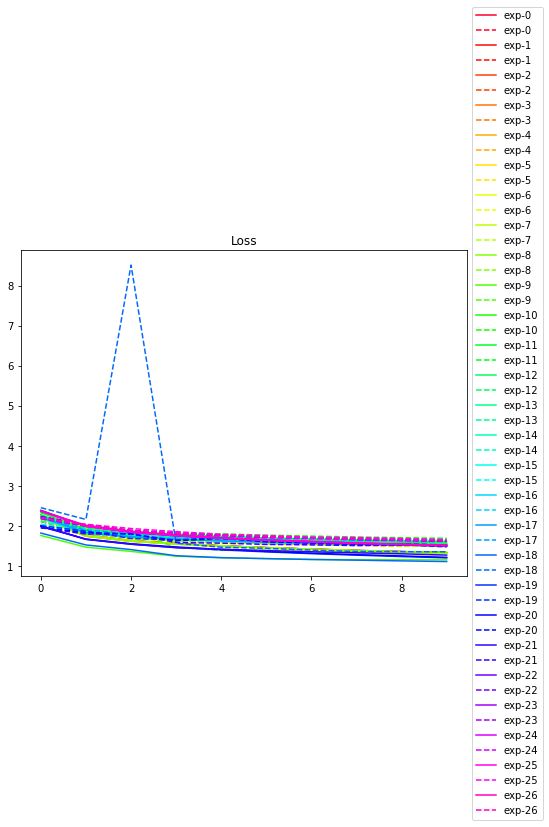

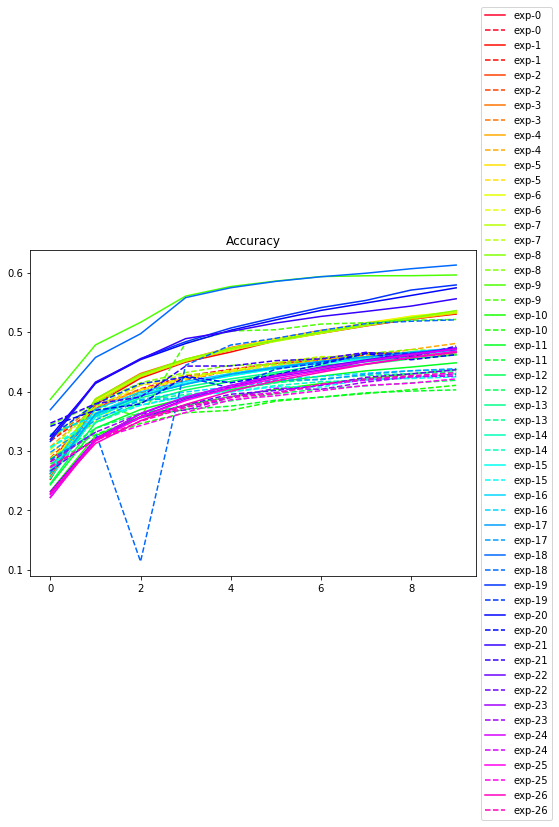

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()